True
1
NVIDIA GeForce RTX 2070 SUPER
Training on device cuda


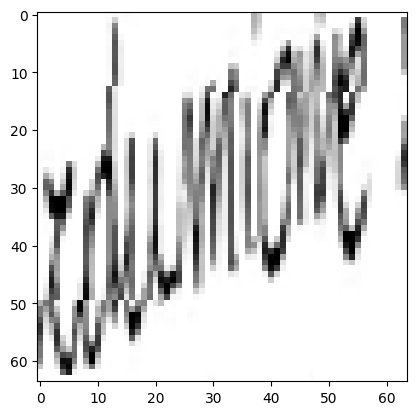

Epoch 1/200, Loss: 6.3781, Val Accuracy: 0.0348, Test Accuracy: 0.0383
Epoch 2/200, Loss: 5.9826, Val Accuracy: 0.0647, Test Accuracy: 0.0657
Epoch 3/200, Loss: 5.7754, Val Accuracy: 0.1164, Test Accuracy: 0.0930
Epoch 4/200, Loss: 5.6010, Val Accuracy: 0.1343, Test Accuracy: 0.1184
Epoch 5/200, Loss: 5.3973, Val Accuracy: 0.1224, Test Accuracy: 0.1124
Epoch 6/200, Loss: 5.2311, Val Accuracy: 0.1343, Test Accuracy: 0.1328
Epoch 7/200, Loss: 5.0475, Val Accuracy: 0.1692, Test Accuracy: 0.1512
Epoch 8/200, Loss: 4.8854, Val Accuracy: 0.2000, Test Accuracy: 0.1920
Epoch 9/200, Loss: 4.7367, Val Accuracy: 0.2169, Test Accuracy: 0.1990
Epoch 10/200, Loss: 4.6491, Val Accuracy: 0.2358, Test Accuracy: 0.2164
Epoch 11/200, Loss: 4.5074, Val Accuracy: 0.2458, Test Accuracy: 0.2264
Epoch 12/200, Loss: 4.3835, Val Accuracy: 0.2557, Test Accuracy: 0.2294
Epoch 13/200, Loss: 4.2648, Val Accuracy: 0.2517, Test Accuracy: 0.2303
Epoch 14/200, Loss: 4.1899, Val Accuracy: 0.2985, Test Accuracy: 0.2682
E

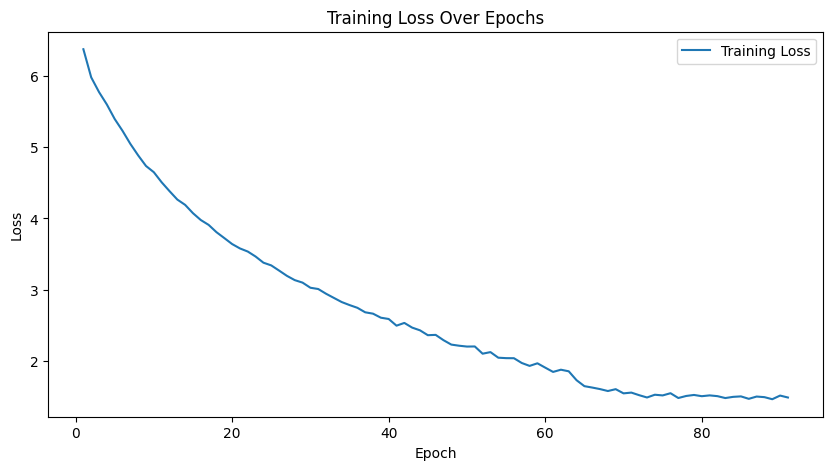

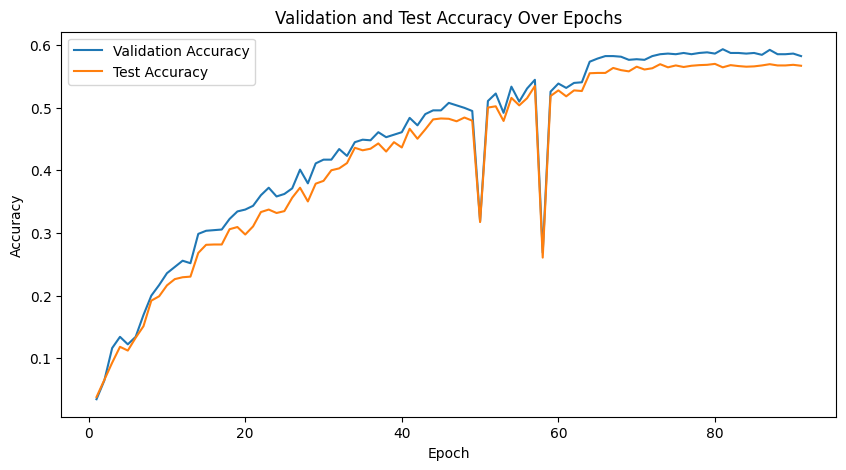

In [5]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# Constants
CSV_PATH = "hpt_dataset.csv"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.001

# Wczytanie danych i kodowanie etykiet
df = pd.read_csv(CSV_PATH)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['word'])

# Filtracja klas występujących mniej niż 2 razy
class_counts = df['label'].value_counts()
valid_classes = class_counts[class_counts >= 3].index
df_filtered = df[df['label'].isin(valid_classes)].copy()  # Tworzymy kopię, aby uniknąć widoku

# Ponowne zakodowanie etykiet po filtracji
label_encoder = LabelEncoder()
df_filtered.loc[:, 'label'] = label_encoder.fit_transform(df_filtered['word'])  # Użycie .loc

# Podział danych
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

def load_images_and_labels(dataframe):
    images, labels = [], []
    for _, row in dataframe.iterrows():
        img_path = row['path']
        label = row['label']  
        image = Image.open(img_path).convert('L')
        image = transform(image)
        images.append(image)
        labels.append(label)
    return torch.stack(images), labels

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(2, fill=255),
    transforms.ToTensor(),
])

# Przygotowanie danych
train_images, train_labels = load_images_and_labels(train_df)
val_images, val_labels = load_images_and_labels(val_df)
test_images, test_labels = load_images_and_labels(test_df)

mean = train_images.mean()
std = train_images.std()
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(5, fill=255),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# Konwersja etykiet na tensory i utworzenie datasetów
dataset_train = TensorDataset(train_images, torch.tensor(train_labels, dtype=torch.long))
dataset_val = TensorDataset(val_images, torch.tensor(val_labels, dtype=torch.long))
dataset_test = TensorDataset(test_images, torch.tensor(test_labels, dtype=torch.long))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# Model z blokami residualnymi i uproszczonymi warstwami liniowymi
num_classes = len(label_encoder.classes_)
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(512 * 4 * 4, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

# Funkcja do obliczania dokładności
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0

# Listy do przechowywania wyników
train_losses = []
val_accuracies = []
test_accuracies = []

# Trening modelu z Early Stopping
def train_model():
    model.to(device)
    early_stopping = EarlyStopping(patience=10)
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, labels in dataloader_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
       
        avg_loss = total_loss / len(dataloader_train)
        train_losses.append(avg_loss)
       
        val_accuracy = calculate_accuracy(model, dataloader_val)
        test_accuracy = calculate_accuracy(model, dataloader_test)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
       
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
        # Early Stopping
        early_stopping(val_accuracy)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        # Scheduler
        scheduler.step(val_accuracy)

plt.imshow(train_images[0][0].cpu().numpy(), cmap="gray")
plt.show()
train_model()

# Wykres straty treningowej
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# Wykres dokładności walidacyjnej i testowej
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation and Test Accuracy Over Epochs")
plt.legend()
plt.show()